In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

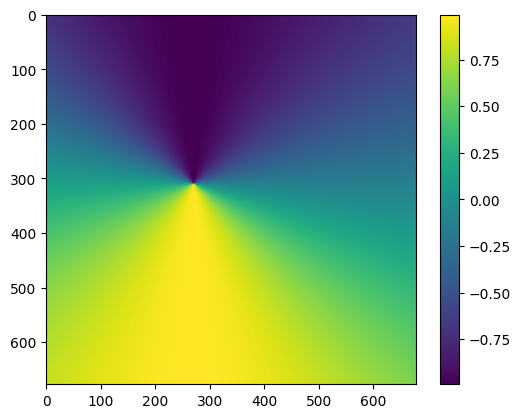

In [4]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_y_arcsec)   #assume this is in arcsec
plt.colorbar()


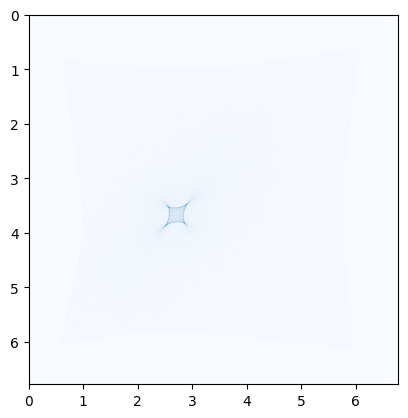

In [3]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 0, 678 * pixscale])
plt.gca().invert_yaxis()

In [5]:
beta = np.array([2.65, 3.055])/pixscale #in pixel
z_s = 2.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)
lensModel = LensModel(lens_model_list=lens_model_list)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_S1 = cosmo.angular_diameter_distance(1.0)
D_S2 = cosmo.angular_diameter_distance(z_s)
D_LS1 = cosmo.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmo.angular_diameter_distance_z1z2(z_l, z_s)
scal = (D_LS1 * D_S2)/(D_LS2 * D_S1)


In [6]:
# lenstronomy
kwargs_mp = {'theta_E': theta_E* pixscale * scal, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens = [kwargs_mp]
solver1 = LensEquationSolver(lensModel)
thetax, thetay = solver1.image_position_analytical(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens)
theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i] , thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical, key=lambda x: x[0])  # sort by x coordinate, in arcsec now

# my class
theta_numerical = cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)


#plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
#plt.scatter(thetax, thetay, color='red', s=10)
#plt.scatter(beta[0], beta[1], color='green', s=10)
#plt.imshow(array_test, cmap='Blues')
#plt.gca().invert_yaxis()
print(beta * pixscale)



for i in range(len(sorted_theta_analytical)):
    print(f'Image {i+1} position: {theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    
    print(f'Difference: {np.sqrt((theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')   



[2.65  3.055]
Image 1 position: (2.0231845223788354, 3.367699878401823)
Predicted Image 1 position: [2.02317641 3.36770655]
Difference: 1.0500775032399572e-05
Image 2 position: (2.225985466974168, 2.601009841385079)
Predicted Image 2 position: [2.2260208 2.6009559]
Difference: 6.448590324470756e-05
Image 3 position: (2.952166439041564, 2.4241367734687285)
Predicted Image 3 position: [2.95216827 2.42412691]
Difference: 1.003740521012346e-05
Image 4 position: (3.09673037273533, 3.4865383988348904)
Predicted Image 4 position: [3.09675255 3.48655904]
Difference: 3.0295045452839315e-05


In [7]:
import time
start = time.time()
cluster_test = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , 2.0, pixscale, 678, diff_z = True)
theta = cluster_test.get_image_positions(2.65, 3.055)

print(time.time()-start)


1.952939748764038


In [8]:
print("Numerical:")
theta = cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)
mag_table = cluster.get_magnifications(theta) #output a dataframe
print(mag_table)

# Analytical magnifications
data_analytical = []
lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
for i in range(len(thetax)):
    x, y = thetax[i], thetay[i]
    mag = lensModel.magnification(thetax[i], thetay[i], kwargs_lens)
    data_analytical.append({'x': x * pixscale, 'y': y * pixscale, 'magnification': mag})
    

table_analytical = pd.DataFrame(data_analytical)
pd.options.display.float_format = '{:.12f}'.format
table_analytical = table_analytical.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table_analytical)

Numerical:
[4.876232867397568, -4.940566774990724, 4.99924614564056, -2.020275886990004]
Analytical:
               x              y   magnification
0 0.020231764093 0.033677065450  4.803379789064
1 0.022260208026 0.026009558986 -5.021316719522
2 0.029521682733 0.024241269051  5.062283378374
3 0.030967525476 0.034865590402 -2.039140130160


In [9]:
# default time delay
print("Numerical:")
theta = cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)
dt = cluster.get_time_delays(beta[0]*pixscale, beta[1]*pixscale, theta)
print(dt)


'''data_dt = []
for i in range(len(theta_numerical)):
    x, y = theta_numerical[i]
    delay = dt[i]       # in days
    data_dt.append({'x': x, 'y': y, 'delta_t': delay})

table = pd.DataFrame(data_dt)
pd.options.display.float_format = '{:.12f}'.format
table = table.sort_values(by=['x', 'y']).reset_index(drop=True)
print(table)'''


# restore the lens model in arcsec
kwargs_sie1 = {'theta_E': theta_E * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0] * pixscale, 'center_y': len_coord[1] * pixscale}
kwargs_lens1 = [kwargs_sie1]


lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
thetax, thetay = solver.image_position_analytical(beta[0]* pixscale, beta[1]*pixscale, kwargs_lens1)
t_analytical = lensModel.arrival_time(thetax , thetay , kwargs_lens1, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - t_analytical[0]

data_dt_analytical = []
for i in range(len(thetax)):
    x, y = theta_analytical[i] * pixscale
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)

Numerical:
(         theta_x        theta_y              d_fermat  delta_t(days)
0 2.023184522572 3.367699878811                   0.0 0.000000000000
1 2.952166439579 2.424136773665  0.004681945747358918 0.389670130528
2 2.225985467021 2.601009841334   0.02802492408093263 2.332465264215
3 3.096730372702 3.486538398865   0.11144878874718506 9.275687161218, array([0.        , 2.33246526, 0.38967013, 9.27568716]))
Analytical:


NameError: name 'solver' is not defined

In [11]:

#test multiple source plane lensing code
# assume the default lens and source position are z_l = 0.5, z_s = 1.0 and thete_E = 1.0
z_l = 0.5
z_s = 2.0
beta = np.array([2.65, 3.055])/pixscale
#numerical stuffs
cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)
print("Numerical:")
theta = cluster_mp.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)
dt = cluster_mp.get_time_delays(beta[0]*pixscale, beta[1]*pixscale,theta)
print(dt[0])

# analytical stuffs
from astropy.cosmology import FlatLambdaCDM
cosmos = FlatLambdaCDM(H0=70, Om0=0.3)

D_S1 = cosmos.angular_diameter_distance(1.0)
D_S2 = cosmos.angular_diameter_distance(z_s)
D_LS1 = cosmos.angular_diameter_distance_z1z2(z_l, 1.0)
D_LS2 = cosmos.angular_diameter_distance_z1z2(z_l, z_s)
factor =  D_LS1 * D_S2 / D_S1 / D_LS2
kwargs_sie2 = {'theta_E': theta_E*factor * pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens_mp = [kwargs_sie2]
lensModel2 = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
solver2 = LensEquationSolver(lensModel2)

print("Analytical:")

thetax, thetay = solver2.image_position_analytical(beta[0]* pixscale, beta[1]* pixscale, kwargs_lens_mp)
t_analytical = lensModel2.arrival_time(thetax, thetay, kwargs_lens_mp, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
min_t = min(t_analytical)
dt_analytical = np.zeros(len(theta_numerical))
for i in range(len(thetax)):
    dt_analytical[i] = t_analytical[i] - min_t
data_dt_analytical = []
for i in range(len(thetax)):
    x, y = thetax[i] , thetay[i]
    delay = dt_analytical[i]    # in days
    data_dt_analytical.append({'theta_x': x, 'theta_y': y, 'delta_t': delay})

table1 = pd.DataFrame(data_dt_analytical)
pd.options.display.float_format = '{:.12f}'.format
print(table1)



Numerical:
         theta_x        theta_y              d_fermat  delta_t(days)
0 2.023184522368 3.367699878416                   0.0 0.000000000000
1 2.952166439144 2.424136773538  0.004681945748928551 0.389670130659
2 2.225985466890 2.601009841390   0.02802492408141108 2.332465264255
3 3.096730372743 3.486538398862   0.11144878874792327 9.275687161280
Analytical:
         theta_x        theta_y        delta_t
0 2.023176409293 3.367706545043 0.000000000000
1 2.952168273295 2.424126905084 0.402899466974
2 2.226020802620 2.600955898602 2.411955509813
3 3.096752547564 3.486559040219 9.591619119586


In [12]:
# comparing speed 
#comparing time
import time
start = time.time()
theta = cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale)
cluster.get_time_delays(beta[0]*pixscale, beta[1]*pixscale, theta)
end = time.time()
print("Time taken for my time delay: ", end-start)
start = time.time()
theta = np.array(cluster.get_image_positions(beta[0]*pixscale, beta[1]*pixscale))
lensModel.arrival_time(theta[0][0] / pixscale, theta[0][1]/pixscale, kwargs_lens)
end = time.time()
print("Time taken for lenstronomy time delay: ", end-start)

Time taken for my time delay:  0.8224742412567139
Time taken for lenstronomy time delay:  0.8737187385559082


In [ ]:
import time
beta_test = (2.4256278669405678, 3.725267541907791)
z_l = 0.5
z_s = 1.0
start = time.time()
test = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = False)
theta = np.array(test.get_image_positions(beta_test[0], beta_test[1]))
end = time.time()
print("Time taken for my image position: ", end-start)
start = time.time()
mag = cluster.get_magnifications(theta)
end = time.time()
print("Time taken for my magnification: ", end-start)
start = time.time()
dt = cluster.get_time_delays(beta_test[0], beta_test[1], theta)
end = time.time()
print("Time taken for my time delay: ", end-start)

Time taken for my image position:  1.0422234535217285
Time taken for my magnification:  0.012132644653320312
Time taken for my time delay:  0.0017282962799072266


In [5]:
def generate_random_coordinates(num_points, x_bound, y_bound):
    x_coords = np.random.uniform(x_bound[0], x_bound[1], num_points)
    y_coords = np.random.uniform(y_bound[0], y_bound[1], num_points)
    return x_coords, y_coords

In [14]:
# population of time delays
# test the time delay population

#IMPORTANT: dt misalignment check from here

# generate beta population in arcsec
num_points = 500
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
z_l = 0.5
z_s = 1.0
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)

dt_pop = []
'''for i in tqdm(range(num_points)):
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, betax[i], betay[i], diff_z = False)
    theta = np.array(cluster_mp.get_image_positions())
    dt = cluster_mp.get_time_delays(theta)
    dt_value = dt['delta_t(days)'].values.tolist()
    dt_value = [value for value in dt_value if value != 0]
    dt_pop.append(dt_value)
    #print(dt['delta_t(days)'])'''

#wtf is this, testing the algo?
for i in tqdm(range(num_points)):
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = False) 
    theta = np.array(cluster_mp.get_image_positions(betax[i], betay[i]))
    t = lensModel.arrival_time(theta[:,0], theta[:,1], kwargs_lens1)
    if len(t) == 0:
        continue
    min_t = min(t)
    dt = [t_i - min_t for t_i in t if t_i - min_t != 0]
    dt_pop.append(dt)
print(dt_pop)

  9%|▉         | 45/500 [00:37<06:22,  1.19it/s]


KeyboardInterrupt: 

In [ ]:
# inject stimulated GW events to the time delay population
import pandas as pd
# random select 1000 events and points
num_points = 100
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)
injections = pd.read_csv("injections_summary_O4_0")
injections = injections.sample(n=100)
injections_para = injections[['dl', 'snr', 'z']].copy()
injections_para.insert(0, 'x', betax)
injections_para.insert(1, 'y', betay)
injections_para = injections_para[injections_para['z'] > 0.5].reset_index(drop=True)
print(injections_para['z'].values.tolist())
#print(injections_para)
z_l = 0.5
z_s = injections_para['z'].values.tolist()
betax = injections_para['x'].values.tolist()
betay = injections_para['y'].values.tolist()
snr = injections_para['snr'].values.tolist()
dt_pop = []
for i in tqdm(range(len(z_s))):
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s[i], pixscale, 678, betax[i], betay[i], diff_z = True)
    mag = cluster_mp.get_magnifications() # a table of theta and mag
    if len(mag) == 0:
        continue
    snr_i = snr[i]
    
    for mag_i in mag['magnification']:
        if snr_i * np.sqrt(abs(mag_i)) < 8:
            mag.drop(mag[mag['magnification'] == mag_i].index)
    theta = list(zip(mag['x'].tolist(), mag['y'].tolist()))
    dt = cluster_mp.get_time_delays(theta) # ok
    dt_value = dt['delta_t(days)'].values.tolist() # ok
    dt_value = [value for value in dt_value if value != 0] # ok
    dt_pop.append(dt_value) # ok
    
# need to make it run faster


(array([3., 2., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.]),
 array([   6.27894621,   64.32305156,  122.3671569 ,  180.41126224,
         238.45536758,  296.49947292,  354.54357826,  412.5876836 ,
         470.63178894,  528.67589428,  586.71999962,  644.76410497,
         702.80821031,  760.85231565,  818.89642099,  876.94052633,
         934.98463167,  993.02873701, 1051.07284235, 1109.11694769,
        1167.16105303, 1225.20515837]),
 <BarContainer object of 21 artists>)

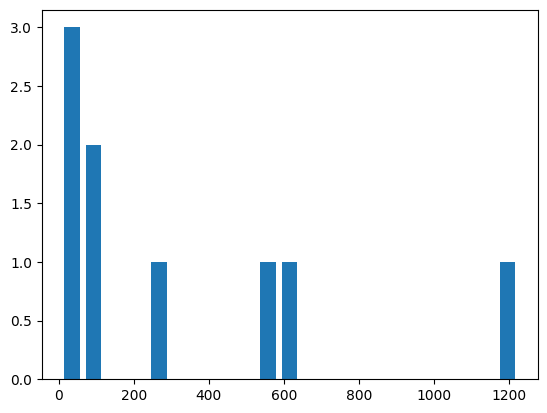

In [ ]:
dt_pop_hist = np.concatenate(dt_pop)
plt.hist(dt_pop_hist, bins=21,rwidth=0.7)

(array([6.4684e+04, 2.8248e+04, 1.2230e+04, 6.6780e+03, 4.0410e+03,
        2.6050e+03, 1.7710e+03, 1.2340e+03, 8.8100e+02, 6.8100e+02,
        4.5500e+02, 3.6000e+02, 2.6800e+02, 2.2800e+02, 1.7500e+02,
        1.3300e+02, 1.0900e+02, 8.8000e+01, 7.2000e+01, 4.8000e+01,
        6.0000e+01, 4.1000e+01, 3.4000e+01, 3.2000e+01, 1.9000e+01,
        8.0000e+00, 1.6000e+01, 8.0000e+00, 8.0000e+00, 7.0000e+00,
        9.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 2.0000e+00,
        3.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([3.72134520e-05, 9.57551222e-01, 1.91506523e+00, 2.87257924e+00,
        3.83009325e+00, 4.78760725e+00, 5.74512126e+00, 6.70263527e+00,
        7.66014928e+00, 8.61766329e+00, 9.57517729e+00, 1.05326913e+01,
        1.14902053e+01, 1.24477193e+01, 1.34052333e+01, 1.43627473e+01,
        1.53202613e+01, 1.6277

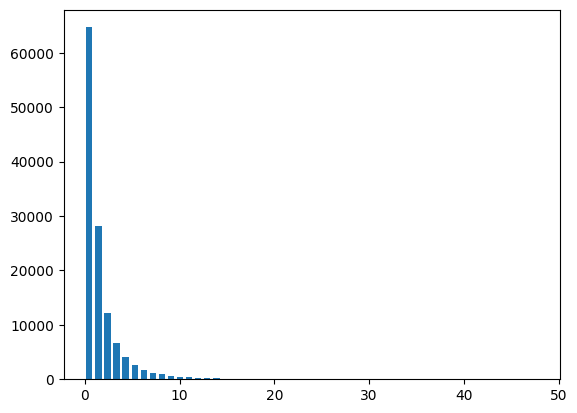

In [7]:
# create new database with z_s values and bin size of 0.05
num_points = 150000
bin_z_s = 0.05
# Rounding function
def round_to_nearest_bin(value, bin_start = 0.55, bin_width = 0.05):
    return round(bin_start + round((value - bin_start) / bin_width) * bin_width,2)


len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)
injections = pd.read_csv("injections_summary_O4_0")
injections = injections.sample(n=num_points)
injections_para = injections[['z', 'snr']].copy()
injections_para.insert(0, 'x', betax)
injections_para.insert(1, 'y', betay)
injections_para = injections_para[injections_para['z'] > 0.55].reset_index(drop=True)

# Add the rounded z values to a new column 'z_s_bin'
injections_para['z_s_bin'] = injections_para['z'].apply(round_to_nearest_bin)
z_l = 0.5
z_s = injections_para['z'].values.tolist()
betax = injections_para['x'].values.tolist()
betay = injections_para['y'].values.tolist()
snr = injections_para['snr'].values.tolist()
z_s_bin = injections_para['z_s_bin'].values.tolist()
# Define the bin centers
bin_centers = np.arange(0.55, max(z_s_bin) + 0.05, 0.05)

# Calculate the bin edges
bin_edges = np.concatenate(([bin_centers[0] - bin_z_s / 2], bin_centers + bin_z_s / 2))

plt.hist(snr, bins=50, rwidth=0.7)

In [11]:
#13/9 my failure start from here

# create new dataframe and save
# new dataframe contains all events with z >0.55
num_points = 150000
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)

x_bound = (len_coord_arcsec[0] - 1 , len_coord_arcsec[0] + 1) 
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)  
betax, betay = generate_random_coordinates(num_points, x_bound, y_bound)
injections = pd.read_csv("injections_summary_O4_0")
injections_para = injections[['snr', 'z']].copy()
injections_para.insert(0, 'x', betax)
injections_para.insert(1, 'y', betay)
injections_para = injections_para[injections_para['z'] > 0.55].reset_index(drop=True)
injections_para.sort_values(by= 'z', inplace=True)
injections_para.to_csv("injections_summary_O4_0_z0.55.csv", index=False)


In [12]:
# try 4900 beta*40 z_s events
# Constants
num_source_coords = 4900
num_redshift_bins = 40
total_events = 196000

injections_para = pd.read_csv("injections_summary_O4_0_z0.55.csv")
# Generate 4900 different source coordinates
len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1, len_coord_arcsec[0] + 1)
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)
src_x = np.linspace(x_bound[0], x_bound[1], 70) # 70 elements along the line
src_y = np.linspace(y_bound[0], y_bound[1], 70)
source_coords = np.meshgrid(src_x, src_y)
source_coords = np.array([source_coords[0].flatten(), source_coords[1].flatten()])
source_coords_repeated = np.tile(source_coords, num_redshift_bins)

# sample snr from konstantin's data and the corresponding redshifts
snr = injections_para['snr'].values.tolist()
z_s = injections_para['z'].values.tolist()
snr_resampled_indices = np.random.choice(len(snr), total_events, replace=True)

z_s = np.array(z_s)
snr = np.array(snr)

z_s_resampled = z_s[snr_resampled_indices]
snr_resampled = snr[snr_resampled_indices]

# Create DataFrame
injections_para = pd.DataFrame({
    'x': source_coords_repeated[0],     #no use for now
    'y': source_coords_repeated[1],     #no use for now
    'z_s': z_s_resampled,
    'snr': snr_resampled
})
print(injections_para.head())

# Save DataFrame to CSV
injections_para.to_csv("injections_summary_O4_0_z0.55-2.40.csv", index=False)



          x    y       z_s       snr
0  1.700000  2.1  0.626023  2.318663
1  1.728986  2.1  1.227664  0.943369
2  1.757971  2.1  1.791608  0.138750
3  1.786957  2.1  2.000853  0.231328
4  1.815942  2.1  1.022398  1.175791


In [9]:
def round_nearest(x, a = 0.05):
    return round(round(x/a)*a, 2)

In [14]:


injections_para['z_s_bin'] = injections_para['z_s'].apply(round_nearest)
injections_para.sort_values(by='z_s_bin', inplace=True)
injections_para.to_csv("injections_summary_O4_0_z0.55-2.40.csv", index=False)

In [7]:
#13/9: should be the z_s originally here make the code fked up
# removed the z_s from the dataframe, need to refer to the real z_s needed in the next cell 

#square sampling

len_coord_arcsec = (len_coord[0] * pixscale, len_coord[1] * pixscale)
x_bound = (len_coord_arcsec[0] - 1, len_coord_arcsec[0] + 1)
y_bound = (len_coord_arcsec[1] - 1, len_coord_arcsec[1] + 1)
src_x = np.linspace(x_bound[0], x_bound[1], 70) # 70 elements along the line
src_y = np.linspace(y_bound[0], y_bound[1], 70)
redshifts = np.random.uniform(0.55, 2.42, 4900)
source_coords = np.meshgrid(src_x, src_y)
source_coords = np.array([source_coords[0].flatten(), source_coords[1].flatten()])
# Create DataFrame
injections_para = pd.DataFrame({
    'x': source_coords[0],
    'y': source_coords[1],
    'z_s': redshifts
})
injections_para.to_csv("betapoints.csv", index=False)

In [7]:
injection_test = pd.read_csv("betapoints.csv").sample(n=10)
injection_test.to_csv("betapoints.csv", index=False)


In [48]:
# 16/9: solve the problem of incorrect theta due to not rounded z_s, need remake the table
events = pd.read_csv("injections_summary_O4_0_z0.55-2.40.csv")
events_by_z = events.groupby('z_s_bin')
injections_para = pd.read_csv("betapoints.csv")

results = []
for i in tqdm(range(len(injections_para))): # cal 4900 iterations
    try:

        z_s = injections_para.loc[i,'z_s']
        z_s = round_nearest(z_s)
        x = injections_para.loc[i,'x']
        y = injections_para.loc[i,'y']
        cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , 
                                z_s, pixscale, 678, diff_z = True)
        theta = np.array(cluster_mp.get_image_positions(injections_para.loc[i,'x'], 
                                                    injections_para.loc[i, 'y']))
        mag = cluster_mp.get_magnifications(theta)
        group = events_by_z.get_group(z_s)      #each gp have same z_s_bin
        for _, event in group.iterrows():
            theta_list = []
            mag_list = []

            for theta_pos, mag_i in zip(theta, mag):
                snr_mag = event['snr'] * np.sqrt(abs(mag_i))

                if snr_mag >= 8:
                    theta_list.append((theta_pos[0], theta_pos[1]))
                    mag_list.append(mag_i)

            if theta_list:
                results.append({'x': x, 'y': y, 
                            'z_s': event['z_s_bin'], 'snr': event['snr'],
                            'theta': theta_list, 'magnification': mag_list})
    except IndexError as e:
        print(f"IndexError at index {i}: {e}")
        # Optionally, you can break the loop or continue
        continue
        
results_df = pd.DataFrame(results)
results_df.sort_values(by=['x','y'], inplace=True)
results_df.to_csv("data_for_dt.csv", index=False)
print(results_df.head())


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

1.7000000000000002 2.1 [[1.28072189 1.68072189]]


In [16]:
results_test = pd.read_csv("data_for_dt.csv")
results_test = results_test.sort_values(by=['x', 'y']).reset_index(drop=True)
print(results_test[0:20])

      x         y   z_s       snr                                       theta  \
0   1.7  2.100000  2.35  6.600235  [(1.2811539616967553, 1.6811539616969333)]   
1   1.7  2.100000  2.35  7.227376  [(1.2811539616967553, 1.6811539616969333)]   
2   1.7  2.100000  2.35  6.379468  [(1.2811539616967553, 1.6811539616969333)]   
3   1.7  2.100000  2.35  6.600235  [(1.2811539616967553, 1.6811539616969333)]   
4   1.7  2.100000  2.35  7.227376  [(1.2811539616967553, 1.6811539616969333)]   
5   1.7  2.128986  1.55  9.637108  [(1.2061011525549026, 1.6575833104621363)]   
6   1.7  2.128986  1.55  6.545607  [(1.2061011525549026, 1.6575833104621363)]   
7   1.7  2.128986  1.55  7.643541  [(1.2061011525549026, 1.6575833104621363)]   
8   1.7  2.128986  1.55  6.104545  [(1.2061011525549026, 1.6575833104621363)]   
9   1.7  2.128986  1.55  7.047269  [(1.2061011525549026, 1.6575833104621363)]   
10  1.7  2.128986  1.55  8.930252  [(1.2061011525549026, 1.6575833104621363)]   
11  1.7  2.128986  1.55  9.7

In [42]:
# delete the rows with no theta values
results_df = pd.read_csv("data_for_dt.csv")
results_df = results_df[results_df['theta'].apply(lambda x: len(x) > 0)]
results_df.to_csv("data_for_dt.csv", index=False)
print(results_df.head())

     x    y   z_s       snr                                       theta  \
0  1.7  2.1  2.35  6.600235  [(1.2811539616967553, 1.6811539616969333)]   
1  1.7  2.1  2.35  7.227376  [(1.2811539616967553, 1.6811539616969333)]   
2  1.7  2.1  2.35  6.379468  [(1.2811539616967553, 1.6811539616969333)]   
3  1.7  2.1  2.35  6.600235  [(1.2811539616967553, 1.6811539616969333)]   
4  1.7  2.1  2.35  7.227376  [(1.2811539616967553, 1.6811539616969333)]   

          magnification  
0  [1.6496025439307889]  
1  [1.6496025439307889]  
2  [1.6496025439307889]  
3  [1.6496025439307889]  
4  [1.6496025439307889]  


In [43]:
# caluclate time delays
results = pd.read_csv("data_for_dt.csv")
results_test = results.sample(n=2000)

def calculate_dt_dataframe(row):
    x_src = row['x']
    y_src = row['y']
    image_positions = eval(row['theta'])  # Convert string representation of list to actual list
    cluster_mp = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , row['z_s'], pixscale, 678, diff_z = True)
    time_delays = cluster_mp.all_dt(x_src, y_src, image_positions)
    return time_delays

tqdm.pandas()
results_test['delta_t'] = results_test.progress_apply(calculate_dt_dataframe, axis=1)
print(results_test.sort_values(by=['x', 'y']).reset_index(drop=True))
results_test.to_csv("dt_distribution.csv", index=True)

100%|██████████| 2000/2000 [00:06<00:00, 323.94it/s]

        x         y   z_s        snr  \
0     1.7  2.157971  0.75   4.566920   
1     1.7  2.302899  0.60  10.826763   
2     1.7  2.447826  1.10   6.409485   
3     1.7  2.621739  1.80   8.576694   
4     1.7  2.650725  0.60  10.826763   
...   ...       ...   ...        ...   
1995  3.7  3.665217  1.05   6.475910   
1996  3.7  3.781159  1.20  11.744445   
1997  3.7  3.868116  0.90  13.606397   
1998  3.7  3.868116  0.90   7.173502   
1999  3.7  4.100000  1.45   9.006283   

                                           theta          magnification  \
0     [(0.6023583874733666, 1.1867495111585082)]    [3.176280933606984]   
1       [(4.070966853848192, 4.309262332982178)]  [-0.7993351746354331]   
2      [(0.9314604248970593, 2.085371490796623)]   [2.1036597506891574]   
3     [(1.0603766349330432, 2.4448565323451175)]   [1.7977447278223015]   
4      [(4.1064321398749675, 4.027905016805508)]  [-0.8950859150527243]   
...                                          ...                    .

1997.6812257994322


(array([596., 106.,  75.,  56.,  49.,  29.,  41.,  28.,  16.,  20.,   7.,
         11.,   8.,  13.,   8.,   1.,   5.,   5.,   2.,   7.,   4.]),
 array([5.90056655e-12, 9.51276774e+01, 1.90255355e+02, 2.85383032e+02,
        3.80510710e+02, 4.75638387e+02, 5.70766065e+02, 6.65893742e+02,
        7.61021419e+02, 8.56149097e+02, 9.51276774e+02, 1.04640445e+03,
        1.14153213e+03, 1.23665981e+03, 1.33178748e+03, 1.42691516e+03,
        1.52204284e+03, 1.61717052e+03, 1.71229819e+03, 1.80742587e+03,
        1.90255355e+03, 1.99768123e+03]),
 <BarContainer object of 21 artists>)

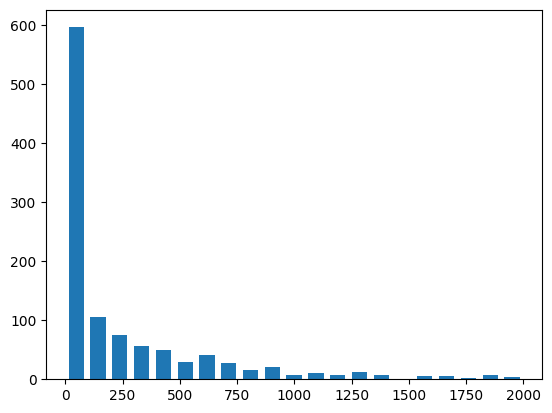

In [34]:
# plot the results of delta_t in a histogram
filtered_results = results_test[results_test['delta_t'].apply(lambda x: len(x) > 0 and
                                                               np.all(x < 2000))]
# Convert the filtered 'delta_t' column to a list of arrays
dt_values = filtered_results['delta_t'].values.tolist()
print(max([max(x) for x in dt_values]))
dt_values_hist = np.concatenate(dt_values)
plt.hist(dt_values_hist, bins=21, rwidth=0.7)

In [40]:
# find the very large time delays
indices = results_test[results_test['delta_t'].apply(lambda arr: np.any(np.array(arr) > 1999))].index
print(indices)
print(results_test.loc[1627066])

Index([1627066, 1648561,  271275, 1627844,  573265,  573002, 1672870, 1710472,
       1433597,  939900,  939756, 1695454, 1755265, 1627439,  573149, 1432600,
       1705950,  391643,  573088, 1627187, 1743512, 1743353, 1706767,  573674,
        804818, 1627791],
      dtype='int64')
x                                                         3.468116
y                                                         2.621739
z_s                                                            0.6
snr                                                       6.383289
theta            [(0.18935129530509037, 3.2669096927311614), (6...
magnification            [-4.2670816271497625, 2.6318597921790716]
delta_t                                       [2109.4872455983054]
Name: 1627066, dtype: object
